In [1]:
import os
import pickle
import sys
sys.path.append('..')
from src.core.evaluator import Evaluator
from src.core.keyboard import Serial
from src.data.layouts.keyboard_genotypes import LAYOUT_DATA

Read file: '../src/data/keyboards/ansi_60_percent.json'
Calculating distance
Distance Calculator Invoked
Obtained '7ab8d9e444d24cdc0b50bc9cd265a306' hash for current keyboard
Loading Cache
ERROR: Data file not found: src/data/distance/distances.pkl
Calculating costs
Identified keys of each finger
Calculating all possible movements and caching in 2D matrix
cost's for this keyboard have been cached in 2D matrix
Saved cache
Layout Loaded Keyboard

LAYOUT DEBUG - ALL LAYERS

LAYER 0: 0  :CHAR         =('`', '~')       
 | 1  :CHAR         =('1', '!')        | 2  :CHAR         =('2', '@')        | 3  :CHAR         =('3', '#')       
 | 4  :CHAR         =('4', '$')        | 5  :CHAR         =('5', '%')        | 6  :CHAR         =('6', '^')       
 | 7  :CHAR         =('7', '&')        | 8  :CHAR         =('8', '*')        | 9  :CHAR         =('9', '(')       
 | 10 :CHAR         =('0', ')')        | 11 :CHAR         =('-', '_')        | 12 :CHAR         =('=', '+')       
 | 13 :CONTROL     

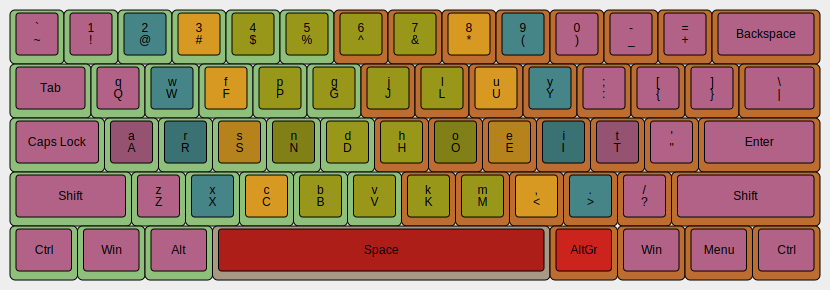

In [2]:

with open('../src/data/keyboards/ansi_60_percent.json', 'r') as f:
    keyboard = Serial.parse(f.read())


ev = Evaluator(debug=True).load_keyoard(keyboard_file='../src/data/keyboards/ansi_60_percent.json')\
    .load_distance().load_layout()

ev.layout.querty_based_remap(LAYOUT_DATA["new1"])

ev.render_layout()

# keyboard.remap_to_keys(LAYOUT_DATA['asset'])

# keyboard.remap_to_keys(list(r"cpdgkeqasm[\]jluho;,trx.yzn/'fiwvb"))
# keyboard.remap_to_keys(list(r"x,fjkwisa'[\]l;gnrht/u.yzqocpdmveb"))
# keyboard.remap_to_keys(list(r"cmdlkegjfr[]\astqhpnioy'zbwvx;u,./"))



In [ ]:

show_keyboard(keyboard.get_physical_keyboard_with_costs())

In [ ]:
import matplotlib.pyplot as plt

# Collect fitness values
fitness_values = []
layout_keys = []

for key, value in LAYOUT_DATA.items():
    print(key)
    keyboard.remap_to_keys(value)
    fitness = keyboard.fitness(data['simple_wikipedia'])  # Store the returned fitness value
    fitness_values.append(fitness)
    layout_keys.append(key)
    show_keyboard(keyboard.get_phisical_keyboard())

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed
import copy
import multiprocessing as mp
from kle.kle_model import Keyboard, FingerName, Hand
from keyboard_phenotype import KeyboardPhenotype
import pickle

# Configuration - use actual CPU count for optimal performance
NUM_PROCESSES = mp.cpu_count()  # This will use all available CPU cores
print(f"Using {NUM_PROCESSES} processes for parallel evaluation")

# Blacklist specific dataset
BLACKLISTED_DATASET = ['cartigratis']
DATASETS = data

def combine_datasets(datasets, blacklisted_datasets=None):
    """
    Combine multiple datasets into a single averaged dataset
    """
    if blacklisted_datasets is None:
        blacklisted_datasets = []
    
    # Filter out blacklisted datasets
    filtered_datasets = {k: v for k, v in datasets.items() 
                        if k not in blacklisted_datasets}
    
    if not filtered_datasets:
        raise ValueError("No datasets available after filtering")
    
    # Initialize combined dataset structure
    combined_markov_chain = defaultdict(lambda: {
        'count': 0,
        'global_percentage': 0.0,
        'category_percentage': 0.0,
        'category': '',
        'next': defaultdict(lambda: {'count': 0, 'percentage': 0.0})
    })
    
    # Sum up all datasets
    dataset_count = len(filtered_datasets)
    
    for dataset_name, dataset_data in filtered_datasets.items():
        markov_data = dataset_data['markov_chain']
        
        for key, key_data in markov_data.items():
            # Average the main key statistics
            combined_markov_chain[key]['count'] += key_data.get('count', 0)
            combined_markov_chain[key]['global_percentage'] += key_data.get('global_percentage', 0.0)
            combined_markov_chain[key]['category_percentage'] += key_data.get('category_percentage', 0.0)
            
            # Take category from first occurrence (they should be the same)
            if not combined_markov_chain[key]['category']:
                combined_markov_chain[key]['category'] = key_data.get('category', '')
            
            # Sum up the 'next' transitions
            if 'next' in key_data:
                for next_key, next_data in key_data['next'].items():
                    combined_markov_chain[key]['next'][next_key]['count'] += next_data.get('count', 0)
                    combined_markov_chain[key]['next'][next_key]['percentage'] += next_data.get('percentage', 0.0)
    
    # Average the values
    for key, key_data in combined_markov_chain.items():
        key_data['global_percentage'] /= dataset_count
        key_data['category_percentage'] /= dataset_count
        
        # Average the 'next' percentages
        for next_key, next_data in key_data['next'].items():
            next_data['percentage'] /= dataset_count
    
    # Convert defaultdict back to regular dict for consistency
    final_combined = {}
    for key, key_data in combined_markov_chain.items():
        final_combined[key] = {
            'count': key_data['count'],
            'global_percentage': key_data['global_percentage'],
            'category_percentage': key_data['category_percentage'],
            'category': key_data['category'],
            'next': dict(key_data['next'])
        }
    
    return {'markov_chain': final_combined}

def evaluate_single_layout_process(args):
    """
    Evaluate a single layout in a separate process.
    Takes a tuple of arguments for multiprocessing compatibility.
    """
    layout_key, layout_value, base_keyboard_data, combined_dataset, qwerty_layout, depth = args
    
    try:
        # Create a fresh keyboard phenotype for this process
        thread_keyboard = KeyboardPhenotype(base_keyboard_data, {})
        thread_keyboard.select_remap_keys(qwerty_layout)
        thread_keyboard.remap_to_keys(layout_value)
        
        print(f"Process evaluating layout: {layout_key}")
        fitness = thread_keyboard.fitness(combined_dataset, depth=depth)
        
        return layout_key, fitness
        
    except Exception as e:
        print(f"Error evaluating layout {layout_key}: {str(e)}")
        return layout_key, float('inf')  # Return infinite fitness for failed layouts

def create_layout_batches(layout_items, num_processes):
    """
    Create balanced batches of layouts for each process to minimize idle time.
    """
    # Sort layouts by estimated complexity (you could use layout name length as a simple heuristic)
    # For now, just distribute evenly
    batch_size = len(layout_items) // num_processes + 1
    batches = []
    
    for i in range(0, len(layout_items), batch_size):
        batch = layout_items[i:i + batch_size]
        if batch:  # Only add non-empty batches
            batches.append(batch)
    
    return batches

def evaluate_layout_batch(args):
    """
    Evaluate multiple layouts in a single process to reduce process creation overhead.
    """
    batch, base_keyboard_data, combined_dataset, qwerty_layout, depth = args
    
    results = []
    for layout_key, layout_value in batch:
        try:
            # Create a fresh keyboard phenotype for this layout
            thread_keyboard = KeyboardPhenotype(base_keyboard_data, {})
            thread_keyboard.select_remap_keys(qwerty_layout)
            thread_keyboard.remap_to_keys(layout_value)
            
            print(f"Process evaluating layout: {layout_key}")
            fitness = thread_keyboard.fitness(combined_dataset, depth=depth)
            results.append((layout_key, fitness))
            
        except Exception as e:
            print(f"Error evaluating layout {layout_key}: {str(e)}")
            results.append((layout_key, float('inf')))
    
    return results

if __name__ == '__main__':
    # Combine all datasets (except blacklisted) into one averaged dataset
    print("Combining datasets...")
    combined_dataset = combine_datasets(DATASETS, BLACKLISTED_DATASET)
    print(f"Combined {len([k for k in DATASETS.keys() if k not in BLACKLISTED_DATASET])} datasets")

    # Load the base keyboard once
    with open('kle_keyboards/ansi_60_percent_hands.json', 'r') as f:
        base_keyboard_raw = Serial.parse(f.read())

    # Collect fitness values for all layouts using parallel processing
    results = {}
    layout_fitness_values = []
    layout_names = []

    print("Evaluating layouts in parallel using multiprocessing...")

    # Convert LAYOUT_DATA to list of items for parallel processing
    layout_items = list(LAYOUT_DATA.items())
    print(f"Total layouts to evaluate: {len(layout_items)}")

    # Create batches for more efficient processing
    layout_batches = create_layout_batches(layout_items, NUM_PROCESSES)
    print(f"Created {len(layout_batches)} batches for {NUM_PROCESSES} processes")

    # Prepare arguments for each batch
    batch_args = [
        (batch, base_keyboard_raw, combined_dataset, LAYOUT_DATA['qwerty'], 8)
        for batch in layout_batches
    ]

    # Process layouts in parallel using separate processes
    with ProcessPoolExecutor(max_workers=NUM_PROCESSES) as executor:
        # Submit batch evaluation tasks
        future_to_batch = {
            executor.submit(evaluate_layout_batch, batch_arg): i 
            for i, batch_arg in enumerate(batch_args)
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_batch):
            try:
                batch_results = future.result()
                for layout_key, fitness in batch_results:
                    results[layout_key] = fitness
                    layout_fitness_values.append(fitness)
                    layout_names.append(layout_key)
                    print(f"Completed: {layout_key} -> {fitness:,.2f}")
                    
            except Exception as exc:
                batch_id = future_to_batch[future]
                print(f"Batch {batch_id} generated an exception: {exc}")

    # Sort layouts by fitness (increasing order - lower is better)
    sorted_data = sorted(zip(layout_names, layout_fitness_values), key=lambda x: x[1])
    sorted_layouts, sorted_fitness_values = zip(*sorted_data)

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sorted_layouts, sorted_fitness_values)

    # Color the bars - best layout in green, worst in red, others in blue
    if len(bars) > 0:
        bars[0].set_color('green')  # Best (lowest fitness)
        if len(bars) > 1:
            bars[-1].set_color('red')   # Worst (highest fitness)
        for bar in bars[1:-1]:
            bar.set_color('blue')

    plt.xlabel('Layout')
    plt.ylabel('Fitness Value (Combined Datasets)')
    plt.title('Fitness Values for Different Layouts (Combined Dataset Average)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add value labels on bars
    for i, (layout, fitness) in enumerate(zip(sorted_layouts, sorted_fitness_values)):
        plt.text(i, fitness + max(sorted_fitness_values) * 0.01, 
                 f'{fitness:,.0f}', ha='center', va='bottom', fontsize=8)

    plt.show()

    # Print results summary
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    for i, (layout, fitness) in enumerate(zip(sorted_layouts, sorted_fitness_values)):
        rank = i + 1
        print(f"{rank:2d}. {layout:15s}: {fitness:12,.2f}")
    print("="*50)

In [ ]:

with open('kle_keyboards/dactyl_manuform_6x6_4_hands.json', 'r') as f:
    keyboard = Serial.parse(f.read())

keyboard = KeyboardPhenotype(keyboard, {})

# keyboard.select_remap_keys(LAYOUT_DATA['qwerty'])
# keyboard.remap_to_keys(LAYOUT_DATA['asset'])
keyboard.fitness(data['simple_wikipedia'])
show_keyboard(keyboard.get_phisical_keyboard())


In [ ]:
show_keyboard(keyboard.get_physical_keyboard_with_costs())

In [ ]:
keyboard.select_remap_keys(LAYOUT_DATA['qwerty'])
keyboard.remap_to_keys(LAYOUT_DATA['asset'])
keyboard.fitness(data['simple_wikipedia'])
show_keyboard(keyboard.get_phisical_keyboard())